<a href="https://colab.research.google.com/github/tonygk4u/Tradingbeginner/blob/master/dsintrading.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
!pip install nsepy

  Stored in directory: /root/.cache/pip/wheels/88/89/1e/3dfa14f863314a42481d8926d9ef4825da5d899e026435fc3a
Successfully built nsepy


Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use tf.cast instead.
Epoch 1/1
 - 88s - loss: 0.0034


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:77: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/usr/local/lib/python3.6/dist-packages/pandas/plotting/_converter.py:129: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


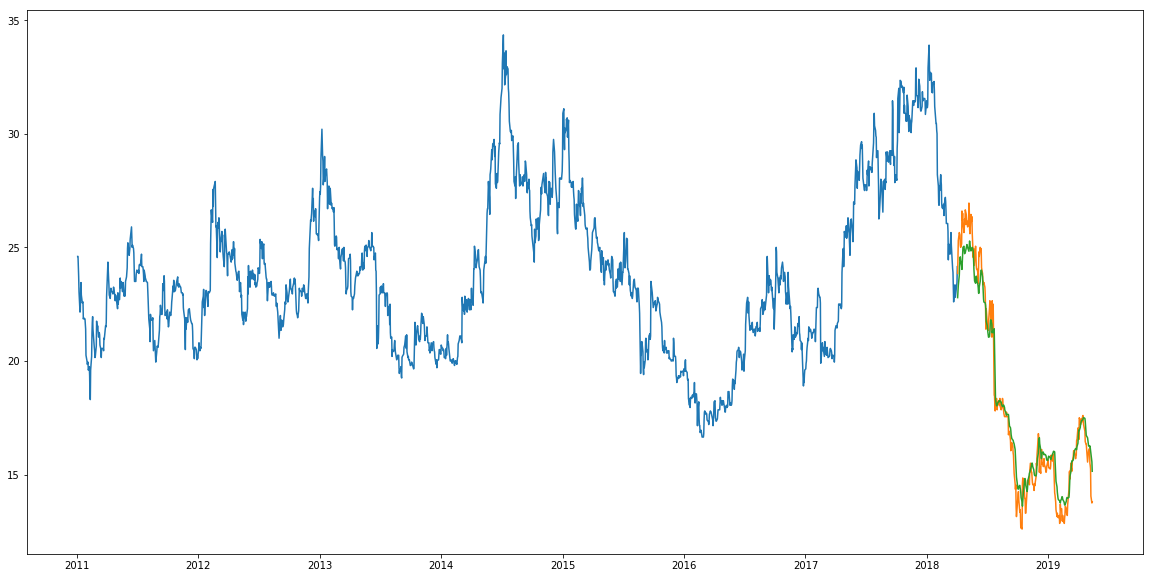

In [4]:
import pandas as pd
import numpy as np
from nsepy import get_history
from datetime import date
#to plot within notebook
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, Dropout, LSTM
from matplotlib.pylab import rcParams
#%matplotlib qt


#setting figure size
rcParams['figure.figsize'] = 20,10

#for normalizing data
scaler = MinMaxScaler(feature_range=(0, 1))


#fetch historical data for any symbol
data = get_history(symbol="SOUTHBANK", start=date(2011,1,1), end=date(2019,5,14))
#convert to pandas dataframe
#df = pd.DataFrame(data)
#df.head()

#df['Date'] = pd.to_datetime(df.Date,format='%Y-%m-%d')
#df.index = df['Date']

data = data.sort_index(ascending=True, axis=0)
new_data=data
new_data.drop(new_data.columns.difference(['Close',]), 1, inplace=True)

    
dataset = new_data.values
train = dataset[0:1800,:]
valid = dataset[1800:,:]

scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(train)

x_train, y_train = [], []
for i in range(60,len(train)):
    x_train.append(scaled_data[i-60:i,0])
    y_train.append(scaled_data[i,0])
x_train, y_train = np.array(x_train), np.array(y_train)

x_train = np.reshape(x_train, (x_train.shape[0],x_train.shape[1],1))

# create and fit the LSTM network
model = Sequential()
model.add(LSTM(units=50, return_sequences=True, input_shape=(x_train.shape[1],1)))
model.add(LSTM(units=50))
model.add(Dense(1))

model.compile(loss='mean_squared_error', optimizer='adam')
model.fit(x_train, y_train, epochs=1, batch_size=1, verbose=2)

#predicting 246 values, using past 60 from the train data
inputs = new_data[len(new_data) - len(valid) - 60:].values
inputs = inputs.reshape(-1,1)
inputs  = scaler.transform(inputs)

X_test = []
for i in range(60,inputs.shape[0]):
    X_test.append(inputs[i-60:i,0])
X_test = np.array(X_test)

X_test = np.reshape(X_test, (X_test.shape[0],X_test.shape[1],1))
closing_price = model.predict(X_test)
closing_price = scaler.inverse_transform(closing_price)

rms=np.sqrt(np.mean(np.power((valid-closing_price),2)))

train = new_data[:1800]
valid = new_data[1800:]
valid['Predictions'] = closing_price
plt.plot(train['Close'])
plt.plot(valid[['Close','Predictions']])

